# Retrieving OpenStreetMap data 

This notebook describes the workflow for downloding the OpenStreetMap data used in Votsis et al. 2025 "A socio-spatial extension of the local climate zone typology: its potential in computational urban models and an example from Finnish cities". 

Downloaded data can be found in the folder `osm_data` in this same repository. Please note that the data were downloaded in April 2021 using `osmnx` version 1.0.1 ([Boeing 2017](https://doi.org/10.1016/j.compenvurbsys.2017.05.004)) - the script in this notebook is a bit oudated but describes exactly how the data used in Votsis et al. were acquired. For latest version of `osmnx`, see https://osmnx.readthedocs.io/en/stable/  and documenation of a major update in [Boeing 2024](https://geoffboeing.com/publications/osmnx-paper/).

Contents of this notebook are based on `osmnx` documentation and automating GIS processes course materials (2020 course version). Updated version of the same lesson, featuring `osmnx` 2.0.1 ([Boeing 2024](https://geoffboeing.com/publications/osmnx-paper/)) is available via [pythongis.org, chapter 9: Retrieving OpenStreetMap](https://pythongis.org/part2/chapter-09/nb/00-retrieving-osm-data.html) (Tenkanen, Heikinheimo & Whipp 2025).

References for using these materials: 

- Votsis et al. 2025 journal article (link to be added once published)
- © OpenStreetMap contributors 2021. (see [OSM copyright and license](https://www.openstreetmap.org/copyright))
- [osmnx](https://osmnx.readthedocs.io/en/stable/) ([Boeing 2017](https://doi.org/10.1016/j.compenvurbsys.2017.05.004);  [Boeing 2024](https://geoffboeing.com/publications/osmnx-paper/))
- [pythongis.org](pythongis.org) materials (Tenkanen, Heikinheimo & Whipp 2025).

## OpenStreetMap

OpenStreetMap (OSM) is a free and editable worldmap available at www.openstreetmap.org. OpenStreetMap is a community effort - anyone is free to edit the map as long as they follow the commonly agreed principles. OSM contains data about streets, buildings, services and landuse.  More details about OpenStreetMap and its contents are available in the [OpenStreetMap Wiki](https://wiki.openstreetmap.org/wiki/Main_Page).

When using OSM data, appropriate credit should be given to OpenStreetMap and its contributors, for example like this: © OpenStreetMap contributors [year] ([see OSM Copyright and License](https://www.openstreetmap.org/copyright) for further details).

There are different ways of accessing OSM data for further analysis. This notebook uses `osmnx` Python package that accesses the data via the [OverPass API](http://wiki.openstreetmap.org/wiki/Overpass_API). This notebook has been run using with osmnx version 1.0.1 and Python 3.8 in February 2021. For latest version of `osmnx`, see https://osmnx.readthedocs.io/en/stable/

## Python environment

Please refer to [pythongis.org installation instructions](https://pythongis.org/part1/chapter-01/nb/06-installation.html) for setting up a suitable Python environment. 

In [1]:
import os
import glob
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
# Proxy settings if needed

In [3]:
out_folder = r"osm_data"

### Read in the case areas

In [4]:
# Change to custom folder if needed
data_folder = "slupsu_kunnat"
file = r"SLUPSU_kunnat.shp"

fp = os.path.join(os.path.join(data_folder, file))

In [5]:
case_areas = gpd.read_file(fp)

In [6]:
case_areas.head()

,GML_ID,NATCODE,NAMEFIN,NAMESWE,LANDAREA,FRESHWAREA,SEAWAREA,TOTALAREA,geometry
0,27844761,853,Turku,Åbo,245.66,3.47,57.22,306.35,"POLYGON ((245370.120 6713650.591, 245369.600 6..."
1,27846492,743,Seinäjoki,Seinäjoki,1431.78,37.45,0.00,1469.23,"MULTIPOLYGON (((281740.431 7002279.761, 281845..."
2,27846025,609,Pori,Björneborg,1156.10,61.76,844.14,2062.00,"POLYGON ((222569.955 6816742.728, 222549.467 6..."
3,27845388,245,Kerava,Kervo,30.63,0.16,0.00,30.79,"POLYGON ((398347.983 6702173.082, 398349.107 6..."
4,27853483,564,Oulu,Uleåborg,2971.14,80.20,764.93,3816.27,"MULTIPOLYGON (((455758.027 7241702.760, 455757..."


<AxesSubplot:>

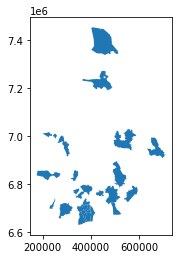

In [7]:
case_areas.plot()

In [8]:
case_areas.crs

<Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Projection

The polygons need to be in WGS84 (EPSG:4326) for osmnx.

In [9]:
case_areas.crs.name

'ETRS89 / TM35FIN(E,N)'

In [10]:
case_areas = case_areas.to_crs(epsg=4326)

In [11]:
case_areas.crs.name

'WGS 84'

## Fetch Points-of-interest

Point-of-interest (POI) is a generic concept that describes point locations that represent places of interest. 
In OpenStreetMap, many POIs are described using the [amenity-tags](https://wiki.openstreetmap.org/wiki/Key:amenityhttps://wiki.openstreetmap.org/wiki/Key:amenity). 
We can, for excample, retrieve all restaurat locations by referring to the tag `amenity=restaurant`. See all available amenity categories from [OSM wiki](https://wiki.openstreetmap.org/wiki/Key:amenity). Various kinds of shops are tagged using [shop-tags](https://wiki.openstreetmap.org/wiki/Key:shop).

Here, we will retrieve all shops and amenities for further inspection.

In [12]:
# List key-value pairs for tags
#tags = {"amenity": True, 'shop': True, 'tourism': True}

### Functions for repeating the process

Function for fetching the data:

In [64]:
def get_pois(row, tags, areaname_col="name", cols=[]):
    """Function for fetching OSM data for each row in a polygon geodataframe"""
    
    # GET THE DATA
    print("Fetchin POIs from", row[areaname_col])
    pois = ox.geometries_from_polygon(row.geometry, tags)
    print("Got", len(pois), "objects")
    
    if cols == []:
        cols = list(pois.columns.values)
    
    # Take subset of columns..
    pois = pois[cols]
    
    pois["municipality"] = row[areaname_col]

    return pois

D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Function for saving results per each region as a separate geopackage (Here it was easier to have separate files, could also print out all at once). Polygon geometries are converted to point centroids.

In [65]:
def save_selected(pois, gpkg, amenity_tag_dict, category="amenity"):
    """Save multiple layers to geopackage"""
    
    for key in amenity_tag_dict.keys():
        
        # Select rows based on list of keys
        selected_pois = pois[pois[category].isin(amenity_tag_dict.get(key))].copy()
        
        # Add info of category to new column for potential further use..
        selected_pois["{}_reclass".format(category)] = key
        
        if len(selected_pois) > 0:       
            # Save selected rows to geopackage as new layer
            print("Saving", len(selected_pois), " objects to file ({})..".format(key))
            selected_pois.to_file(gpkg, layer=key, driver="GPKG")
            
        else: 
            print("found no", key)

In [66]:
def save_pois_to_gpkg(pois, gpkg, areaname="", taginfo="", cols=[], renamings={"":""}):
    """Function for saving objects to geodataframe. Converts polygon geom to point before saving"""
    
    ## PREPARE DATA FOR SAVING:
    
    # Save info of original geom type
    pois.loc[pois["geometry"].type=="Point", "source"] = "OSM_point"
    pois.loc[pois["geometry"].type=="Polygon", "source"] = "OSM_polygon"

    # Approximate polygon location using a point centroid 
    # Calculate centroid on-the-fly using a local projection (EPSG:3067)
    if len(pois.loc[pois["geometry"].type=="Polygon"])>0:
        poly_centroids = pois.loc[pois["geometry"].type=="Polygon"].to_crs(3067).centroid.to_crs(4326)
        pois.loc[pois["geometry"].type=="Polygon", "geometry"] = poly_centroids
    
    if cols == []:
        cols = list(pois.columns.values)
    
    pois = pois[cols]
    pois.rename(columns=renamings)
    
    # ALL AMENITIES
    print("Saving", len(pois), "objects to file")
    pois.to_file(gpkg, layer=f"{areaname}_{taginfo}", driver="GPKG")
    
    print("DONE saving data to", gpkg, "\n")

### Custom settings (tags and columns)

In [99]:
# Final list of tags used
tags = {
    'amenity': True,
    'leisure' : True,
    'shop': True, 
    'historic': True, 
    'sport' : True, 
       }

D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
# Get one key-value pair at a time.. (for separate processing..)
for key, value in tags.items():
    temp_dict = {}
    temp_dict[key] = value
    print(temp_dict)

{'amenity': True}
{'leisure': True}
{'shop': True}
{'historic': True}
{'sport': True}


In [103]:
# List of columns to select from the result
cols = ['osmid',
        'name',
        #'amenity',
        #'shop',
        #'tourism',
        #'leisure',
        #'name:fi', 
        'geometry']

# Dictionary for renaming columns. Note! for shapefile output, max 8 characters will be stored!
renamings = {'name:fi': 'name_fi', 
             'addr:city' : 'addr_city', 
             'addr:country' : 'addr_country', 
             'addr:postcode' : 'addr_postcode', 
             'addr:street': 'addr_street'}

## Repeat the process

In [104]:
case_areas.NAMEFIN.unique()

array(['Turku', 'Seinäjoki', 'Pori', 'Kerava', 'Oulu', 'Vantaa', 'Vihti',
       'Kouvola', 'Vaasa', 'Kauniainen', 'Järvenpää', 'Tampere', 'Lahti',
       'Lappeenranta', 'Hämeenlinna', 'Tuusula', 'Hyvinkää', 'Helsinki',
       'Salo', 'Kuopio', 'Rovaniemi', 'Kirkkonummi', 'Riihimäki',
       'Joensuu', 'Sipoo', 'Kotka', 'Mikkeli', 'Espoo', 'Nurmijärvi'],
      dtype=object)

In [105]:
# Get one key-value pair at a time.. (for separate processing..)
for key, value in tags.items():
    temp_dict = {}
    temp_dict[key] = value
    print(temp_dict)
    
    temp_cols = cols.copy()
    temp_cols.append(key)
    print(temp_cols, "\n")

{'amenity': True}
['osmid', 'name', 'geometry', 'amenity'] 

{'leisure': True}
['osmid', 'name', 'geometry', 'leisure'] 

{'shop': True}
['osmid', 'name', 'geometry', 'shop'] 

{'historic': True}
['osmid', 'name', 'geometry', 'historic'] 

{'sport': True}
['osmid', 'name', 'geometry', 'sport'] 



In [106]:
ox.config(timeout=10000)

In [107]:
tags

{'amenity': True,
 'leisure': True,
 'shop': True,
 'historic': True,
 'sport': True}

In [108]:
# Fetch amenities for all case areas (results come stacked into one Pandas Series..)
#results = case_areas.apply(get_pois, tags=tags, cols=[], renamings=renamings, areaname_col="NAMEFIN", axis=1)

In [109]:
#selected_shop_tags = [value for values in shop_tag_dict.values() for value in values]

In [110]:
case_areas.head()

,GML_ID,NATCODE,NAMEFIN,NAMESWE,LANDAREA,FRESHWAREA,SEAWAREA,TOTALAREA,geometry
0,27844761,853,Turku,Åbo,245.66,3.47,57.22,306.35,"POLYGON ((22.36528 60.47831, 22.36528 60.47831..."
1,27846492,743,Seinäjoki,Seinäjoki,1431.78,37.45,0.00,1469.23,"MULTIPOLYGON (((22.67622 63.08385, 22.67848 63..."
2,27846025,609,Pori,Björneborg,1156.10,61.76,844.14,2062.00,"POLYGON ((21.80371 61.38515, 21.80352 61.38402..."
3,27845388,245,Kerava,Kervo,30.63,0.16,0.00,30.79,"POLYGON ((25.15264 60.44299, 25.15266 60.44297..."
4,27853483,564,Oulu,Uleåborg,2971.14,80.20,764.93,3816.27,"MULTIPOLYGON (((26.05129 65.29534, 26.05127 65..."


In [111]:
temp_cols

D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['osmid', 'name', 'geometry', 'sport']

In [112]:
# Get one key-value pair at a time.. (for separate processing..)
for key, value in tags.items():
    temp_dict = {}
    temp_dict[key] = value
    print(temp_dict)
    
    temp_cols = cols.copy()
    temp_cols.append(key)
    print(temp_cols, "\n")
    
    try:
        # Get the data, one key at a time
        results = case_areas.apply(get_pois, tags=temp_dict, cols=temp_cols, areaname_col="NAMEFIN", axis=1)
    except:
        print("stopped.. pr")
        
    # Combine the stacked result dfs into a list and concatenate into one big gdf
    result_list = [result for result in results]
    combined = pd.concat(result_list)
    
    print(key, "results from all municipalities:", len(combined), "records")
    print(combined.head())
    
    # output file name
    gpkg = os.path.join(out_folder, "OpenStreetMap_data_slupsu_16_4_2021.gpkg")

    # Save study area extent 
    #area.to_file(gpkg, layer=f"{area_name}_region", driver="GPKG")

    # Save points
    save_pois_to_gpkg(combined, 
                      gpkg=gpkg,
                      areaname="all",
                      cols=temp_cols,
                      renamings=renamings,
                      taginfo=key
                     )

{'amenity': True}
['osmid', 'name', 'geometry', 'amenity'] 

Fetchin POIs from Turku
Got 4816 objects
Fetchin POIs from Seinäjoki
Got 1163 objects
Fetchin POIs from Pori
Got 836 objects
Fetchin POIs from Kerava
Got 840 objects
Fetchin POIs from Oulu
Got 3773 objects
Fetchin POIs from Vantaa
Got 4490 objects
Fetchin POIs from Vihti
Got 725 objects
Fetchin POIs from Kouvola
Got 3085 objects
Fetchin POIs from Vaasa
Got 1476 objects
Fetchin POIs from Kauniainen
Got 220 objects
Fetchin POIs from Järvenpää
Got 545 objects
Fetchin POIs from Tampere
Got 3632 objects
Fetchin POIs from Lahti
Got 1418 objects
Fetchin POIs from Lappeenranta
Got 1528 objects
Fetchin POIs from Hämeenlinna
Got 1738 objects
Fetchin POIs from Tuusula
Got 858 objects
Fetchin POIs from Hyvinkää
Got 786 objects
Fetchin POIs from Helsinki
Got 18319 objects
Fetchin POIs from Salo
Got 721 objects
Fetchin POIs from Kuopio
Got 1586 objects
Fetchin POIs from Rovaniemi
Got 906 objects
Fetchin POIs from Kirkkonummi
Got 878 object

In [ ]:
### FOR EACH AREA, CREATE SEPARATE GPKG
for i in range(len(case_areas)):
    
    # INITIATE OUTPUT FILE AND SAVE STUDY AREA EXTENT
    area = case_areas[case_areas.index == i]
    area_name = area.at[i, areaname_col]
    print(area_name)
    
    # output file name
    gpkg = os.path.join(out_folder, "OSM_slupsu.gpkg")

    # Save study area extent 
    #area.to_file(gpkg, layer=f"{area_name}_region", driver="GPKG")


    # Save points
    save_pois_to_gpkg(results[i], 
                      gpkg=gpkg,
                      areaname=area_name,
                      cols=cols,
                      renamings=renamings,
                      taginfo="leisure"
                     )

## Explore results

The following scripts can be used to inspect the downloaded data. For Votsis et al. 2015 further processing of the downloaded data was done separately in desktop GIS software. 

In [ ]:
files = glob.glob(os.path.join(out_folder, "*gpkg"))

In [ ]:
files

### Potential duplicates

In [ ]:
def explore_duplicates(gpkg, layer="restaurants"):
    
    print("\n-------", gpkg.split("_")[1][:-5], layer, "- potential duplicates------------")
    
    data = gpd.read_file(gpkg, layer=layer)
    
    #counts = pd.DataFrame(data.name.value_counts(), columns=["count"])
    #print(data.name.value_counts())
    
    counts = pd.DataFrame(data.name.value_counts())
    if len(counts[counts["name"] > 1])>0:
        print(counts[counts["name"] > 1])

for gpkg in files: 
    
    for layer in ["restaurants", "cafes", "pubs_clubs"]:
        explore_duplicates(gpkg, layer)


### Visualize

Simple maps for quick visual check

In [ ]:
import fiona
import contextily as ctx

#package = "OpenStreetMap_cafes_and_restaurants_FEB2021.gpkg"

for gpkg in files: 
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    data = gpd.read_file(gpkg, layer="restaurants")
    layername="{}_restaurants".format(os.path.basename(gpkg).split("_")[1][:-5])
    
    print(layername)
    
    #Re-project for plotting with basemap
    data = data.to_crs(epsg=3857)

    # Fetch amenities for all case areas
    data.plot(ax=ax, column="amenity", legend=True)
    
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    
    plt.axis("off")
    
    plt.savefig(os.path.join("img", layername + ".png"), dpi=300)